# BM40A1401 GPU Computing

## Erik Kuitunen

### Exercise 4

#### Task 1 
Sparse matrices

##### a)
Compare the memory footprint of matrices in dense, COO and CSR -formats. Plot the amount of stored elements against the total number of elements in the matrix. Use sparse matrices with density of 0.01. Use different square matrix sizes to show the difference.

Hint: For COO and CSR formats you will have to find the sizes of vectors they store the data. Check out CuPy Sparse reference.

In [23]:
# Importing necessary libraries
import cupyx as cpx
import numpy as np
import cupy as cp

from matplotlib import pyplot as plt 

In [24]:

matrix_sizes = 2**np.array( range( 3, 12, 1 ) )

A_coo_sizes = []
A_csr_sizes = []
A_dense_sizes = []

for sz in matrix_sizes:
    
    # Creating sparse matrix and converting it to required formats
    A_coo = cpx.scipy.sparse.rand( int( sz ), int( sz ) )
    A_dense = A_coo.todense()  
    A_csr = cpx.scipy.sparse.csr_matrix( A_coo )
    
    # Calculate memory footprint
    A_dense_sizes.append( A_dense.size )
    A_coo_sizes.append( A_coo.data.size + A_coo.row.size + A_coo.col.size)
    A_csr_sizes.append( A_csr.data.size + A_csr.indices.size + A_csr.indptr.size )

Visualizing results

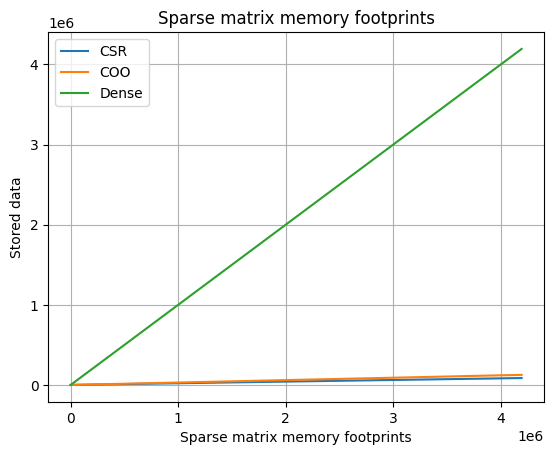

In [25]:
plt.plot( matrix_sizes**2, A_csr_sizes, label = "CSR" )
plt.plot( matrix_sizes**2, A_coo_sizes, label = "COO" ) 
plt.plot( matrix_sizes**2, A_dense_sizes, label = "Dense" ) 

plt.grid()
plt.legend()
plt.title( "Sparse matrix memory footprints" )
plt.xlabel( "Sparse matrix memory footprints" )
plt.ylabel( "Stored data" )

plt.show()

##### b)

Compare the execution times of dot products between a matrix and a vector. Use four different cases for the matrix: Scipy dense, Scipy COO, CuPy dense and CuPy COO. The vector should be in dense-format in all cases.

Time their performance against different sizes of square matrices.

In [26]:
import scipy as sc 
import time

matrix_sizes = 2**np.array( range( 3, 15, 1 ) )

# Initalizing result variable
times_sci_coo = np.zeros( ( matrix_sizes.size, 1) )
times_sci_dense = np.zeros( ( matrix_sizes.size, 1) )
times_cupy_coo = np.zeros( ( matrix_sizes.size, 1) )
times_cupy_dense = np.zeros( ( matrix_sizes.size, 1) )

# Using the same matrix sizes as in a)
ii = 0
for sz in matrix_sizes:
    
    # Creating vector and desired matrices
    vector = np.random.randn( int(sz), 1 )
    
    A_sci_coo = sc.sparse.rand( int(sz), int(sz) )
    A_sci_dense = A_sci_coo.todense()
    
    A_cupy_coo = cpx.scipy.sparse.rand( int(sz), int(sz) )
    A_cupy_dense = A_cupy_coo.todense()
    
    # Measuring execution times
    
    # First SciPy COO and SciPy dense
    start_time = time.perf_counter()
    result = A_sci_coo.dot( vector )
    end_time = time.perf_counter()
    
    times_sci_coo[ii, 0] = ( end_time - start_time ) * 1000
    
    start_time = time.perf_counter()
    result = A_sci_dense.dot( vector )
    end_time = time.perf_counter()
    
    times_sci_dense[ii, 0] = ( end_time - start_time ) * 1000
    
    # Then CuPy COO and CuPy dense
    vector = cp.array( vector )
    
    start_time = time.perf_counter()
    result = A_cupy_coo.dot( vector )
    end_time = time.perf_counter()
    
    times_cupy_coo[ii, 0] = ( end_time - start_time ) * 1000
    
    start_time = time.perf_counter()
    result = cp.dot( A_cupy_dense, vector )
    end_time = time.perf_counter()
    
    times_cupy_dense[ii, 0] = ( end_time - start_time ) * 1000
    
    ii += 1
    

Visualizing results

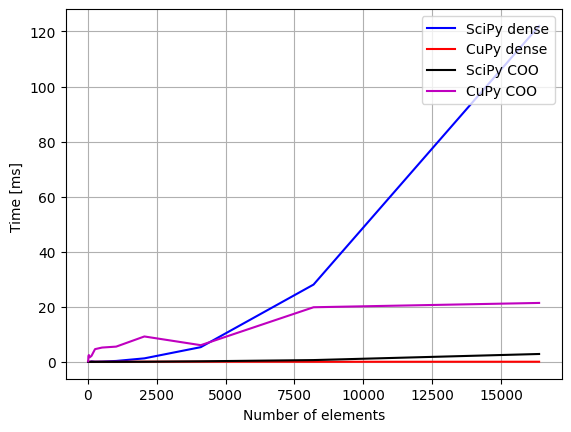

In [133]:
plt.plot( matrix_sizes, times_sci_dense, 'b', label = "SciPy dense")
plt.plot( matrix_sizes, times_cupy_dense, 'r', label = "CuPy dense")
plt.plot( matrix_sizes, times_sci_coo, 'k', label = "SciPy COO")
plt.plot( matrix_sizes, times_cupy_coo, 'm', label = "CuPy COO")

plt.xlabel( 'Number of elements')
plt.ylabel( 'Time [ms] ') 
plt.legend( loc = "upper left" )
plt.grid()

plt.show()

In a) we are dealing with a dense matrix and two different types of sparse matrices. Since sparse matrices store only information regarding nonzero elemtns, the memory footprint for those are much smaller than that of dense matrix.

In the b) plot can be seen that the dot product with dense, non-GPU operated matrix is the slowest. This is because it does not utilize the added performance of GPU and since the multiplications of dot product need to be done with all the elements. With COO matrices, only those multiplications need to be done, where the COO matrix has nonzero elements. This greatly reduces the needed amount of operations. I can't however answer, why the CuPy dense is the fastest, even though there's a lot more computations than with CuPy COO. SciPy COO fares really well against CuPy dense.

#### Task 2
Random numbers

Estimate the value of pi by random sampling. Implement by using both CuPy and Numpy and compare the execution time with million random points.


In [124]:
sizes = np.array( [ 1e4, 1e5, 1e6, 1e7, 2e7, 3e7, 4e7, 5e7 ] )

times_cpu = np.zeros( ( sizes.size, 1 ) )
times_gpu = np.zeros( ( sizes.size, 1 ) )
pi_cpu = np.zeros( ( sizes.size, 1 ) )
pi_gpu = np.zeros( ( sizes.size, 1 ) )

First using NumPy

In [125]:
ii = 0
for N in sizes:   
    
    start_time = time.perf_counter()

    samples = np.random.rand( int(N), 2 ) - 0.5

    # Computing squares of each sample element and performing appropriate matrix multiplication to get N x 1 vector
    # with elements of form x^2 + y^2
    distances = np.dot( np.square( samples ), np.array( [ [1], [1] ] ) )    

    inside_circle = np.less_equal( distances, 0.5**2)       # Check which elements are inside the circle 
    inside_circle = distances[ inside_circle ]              # Picking the elements which are inside the circle

    pi_approx_cpu = inside_circle.size / N * 4      # Calculating the pi approximation

    end_time = time.perf_counter()

    time_cpu = ( end_time - start_time ) * 1000
    
    times_cpu[ii] = time_cpu
    pi_cpu[ii] = pi_approx_cpu
    
    ii += 1



Then with CuPy

In [126]:
ii = 0
for N in sizes:

    start_time = time.perf_counter()

    samples = cp.random.rand( int(N), 2 ) - 0.5     # Generate samples as N x 2 matrix

    # Computing squares of each sample element and performing appropriate matrix multiplication to get N x 1 vector
    # with elements of form x^2 + y^2
    distances = cp.dot( cp.square( samples ), cp.array( [ [1], [1] ] ) )    

    inside_circle = cp.less_equal( distances, 0.5**2)       # Check which elements are inside the circle 
    inside_circle = distances[ inside_circle ]              # Picking the elements which are inside the circle

    pi_approx_gpu = inside_circle.size / N * 4      # Calculating the pi approximation

    end_time = time.perf_counter()

    time_gpu = ( end_time - start_time ) * 1000
    
    times_gpu[ii] = time_gpu
    pi_gpu[ii] = pi_approx_gpu
    
    ii += 1


Results

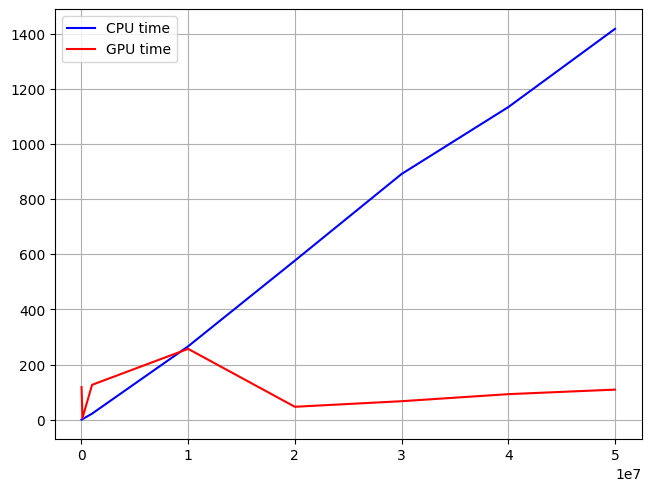

In [132]:

fig, ax = plt.subplots( layout = 'constrained' )

ax.plot( sizes, times_cpu, 'b', label = "CPU time" )
ax.plot( sizes, times_gpu, 'r', label = "GPU time" )

plt.legend( loc = "upper left" )

plt.xscale( "linear")
plt.grid()

plt.show()